## Overview

This notebook shows how you can build a question-answering (Q&A) system (or "bot") over multiple large documents so that Vertex AI PaLM API can answer any questions about the contents of those documents.

Many companies have lots of information stored in documents, but retrieving that information easily and quickly can be challenging. To solve this, you will build a question-answering system powered by PaLM API to enable users to extract or query important details from those documents, which could be in any standard doc format such as .pdf, .doc, .docx, .txt, .pptx, or .html.

The challenge with building a Q&A system over large documents is that you must do more than just pass the entire documents, into the prompts themselves, as the prompt context. This is because LLMs, including [Vertex PaLM API](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/models), have token limits that [restrict how much context you can provide](https://ai.google/static/documents/palm2techreport.pdf).

So how can you build a Q&A system with restrictions on token lengths? To solve this, in addition to your question (your prompt), you will need to provide just the relevant context; context that comes from your closed-domain sources (i.e. the large documents).

In this notebook, you will see three methods that can address the large context challenge, known as:

* **Stuffing** - pushing whole document content as a context.
* **Map-Reduce** - splitting documents in smaller chunks.
* **Map-Reduce - embedding** - creating embeddings of smaller chunks and using vector similarity search to find relevant context.

The notebook introduces you to the fundamental approach towards handling huge documents for building a question-answering bot using Vertex PaLM API and finding relevant context for a user query, keeping the context limitation in check.

In addition, there can be open source or Google Cloud drop-in replacement of steps, which will be discussed later in the notebook.

### Import libraries

In [1]:
import os
import re
import warnings
import numpy as np
import pandas as pd
import textract
from PyPDF2 import PdfReader
from tenacity import retry, stop_after_attempt, wait_random_exponential
from vertexai.language_models import TextEmbeddingModel, TextGenerationModel
import tiktoken  # Token counting library for GPT-like models

warnings.filterwarnings("ignore")

# Load models
generation_model = TextGenerationModel.from_pretrained("text-bison@001")
embedding_model = TextEmbeddingModel.from_pretrained("textembedding-gecko@001")

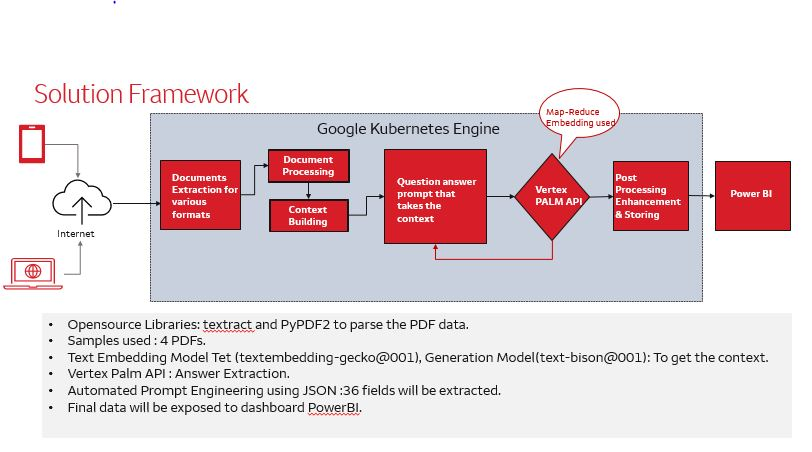

In [2]:
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(3))
def text_generation_model_with_backoff(**kwargs):
    return generation_model.predict(**kwargs).text


@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(3))
def embedding_model_with_backoff(text=[]):
    embeddings = embedding_model.get_embeddings(text)
    return [each.values for each in embeddings][0]

#### Document Processing

When you have documents, you need to process them for downstream consumption. In the processing phase, you aim to read the documents and convert them into a format that the downstream logic can easily use. While reading, you should keep as much metadata as possible from the original document.

In this case, you are loading different file types, such as .pdf, .txt, .docx, and .json. Each file type has its reader, and you can use a simple open-source library called [textract](https://textract.readthedocs.io/en/stable/) and [PyPDF2](https://pypdf2.readthedocs.io/en/3.0.0/) to load them. You can save the file name, file type, page number (shown only for pdf), and content for each file.

This metadata will be essential for quoting the source of information when sending it as a context and answering queries later on.

The metadata and content extracted and processed are necessary because:
* Quote the source of information when sending it as a context.
* Answer queries about the documents.
* Track changes to the documents.
* Identify duplicate documents.
* Organize the documents.


![Embedding Learning](https://storage.googleapis.com/github-repo/img/reference-architecture%20/map_reduce_flow_new.jpeg)

In [3]:
import os
from PyPDF2 import PdfReader  # For searchable PDFs
import fitz  # For handling unsearchable PDFs
import textract  # For handling other file types
path = 'src2'
def files(path):
    """
    Function that returns only filenames if the path is a directory,
    or returns the single file if the path is a file.
    """
    if os.path.isfile(path):
        # If it's a file, yield just that file
        yield path
    elif os.path.isdir(path):
        # If it's a directory, list all files
        for file in os.listdir(path):
            file_path = os.path.join(path, file)
            if os.path.isfile(file_path):
                yield file_path
    else:
        raise NotADirectoryError(f"{path} is neither a file nor a directory")
# Define create_data_packet if not already defined
def create_data_packet(file_name, file_type, page_number, file_content):
    return {
        'file_name': file_name,
        'file_type': file_type,
        'page_number': page_number,
        'file_content': file_content
    }

final_data = []

for file_name in files(path):
    #print(file_name)
    _, file_type = os.path.splitext(file_name)
    
    if file_type == ".pdf":
        # Attempt to load and extract text using PdfReader (for searchable PDFs)
        reader = PdfReader(file_name)
        is_text_extracted = False
        for i, page in enumerate(reader.pages):
            text = page.extract_text()
            if text:
                packet = create_data_packet(
                    file_name, file_type, page_number=int(i + 1), file_content=text
                )
                final_data.append(packet)
                is_text_extracted = True
        
        # If no text was extracted (likely an unsearchable PDF), use fitz (PyMuPDF)
        if not is_text_extracted:
            #print(f"No text found with PdfReader, using fitz for {file_name}")
            doc = fitz.open(file_name)
            for i in range(doc.page_count):
                page = doc.load_page(i)
                text = page.get_text("text")  # Extract text
                if text.strip():  # Ensure non-empty text
                    packet = create_data_packet(
                        file_name, file_type, page_number=int(i + 1), file_content=text
                    )
                    final_data.append(packet)
                else:
                    # If page is still non-text, render page as image (optional)
                    pix = page.get_pixmap()
                    pix.save(f"page-{i + 1}-{file_name}.png")
                    #print(f"Page {i + 1} rendered as image.")
    
    else:
        # For non-PDF file types, use textract
        text = textract.process(file_name).decode("utf-8")
        packet = create_data_packet(
            file_name, file_type, page_number=None, file_content=text
        )
        final_data.append(packet)
    
    # converting the data that has been read from GCS to Pandas DataFrame for easy readibility and downstream logic
    pdf_data = pd.DataFrame.from_dict(final_data)
    pdf_data = pdf_data.sort_values(by=["file_name", "page_number"])  # sorting the datafram by filename and page_number
    pdf_data.reset_index(inplace=True, drop=True)
    # you can check how many different file type you have in our datafrmae.
    # The function get_chunks_iter() can be used to split a piece of text into smaller chunks,
    # each of which is at most maxlength characters long.
    # This can be useful for tasks such as summarization, question answering, and translation.
    ##print("Data has these different file types : \n", pdf_data["file_type"].value_counts())
    # combining all the content of the PDF as single string such that it can be passed as context.
    context = "\n".join(str(v) for v in pdf_data["file_content"].values)
    ##print("The total words in the context: ", len(context))
    def get_chunks_iter(text, maxlength):
        """
        Get chunks of text, each of which is at most maxlength characters long.

        Args:
            text: The text to be chunked.
            maxlength: The maximum length of each chunk.

        Returns:
            An iterator over the chunks of text.
        """
        start = 0
        end = 0
        final_chunk = []
        while start + maxlength < len(text) and end != -1:
            end = text.rfind(" ", start, start + maxlength + 1)
            final_chunk.append(text[start:end])
            start = end + 1
        final_chunk.append(text[start:])
        return final_chunk


    # function to apply "get_chunks_iter" function on each row of dataframe.
    # currently each row here for file_type=pdf is content of each page and for other file_type its the whole document.
    def split_text(row):
        chunk_iter = get_chunks_iter(row, chunk_size)
        return chunk_iter
    global chunk_size
    # you can define how many words should be there in a given chunk.
    chunk_size = 5000

    pdf_data_sample = pdf_data.copy()
    # Token count function using tiktoken
    def count_tokens(prompt):
        # Use tiktoken to count tokens
        enc = tiktoken.get_encoding("p50k_base")  # Choose the appropriate encoding for your model
        tokens = enc.encode(prompt)
        return len(tokens)
        # Remove all non-alphabets and numbers from the data to clean it up.
    # This is harsh cleaning. You can define your custom logic for cleansing here.
    pdf_data_sample["file_content"] = pdf_data_sample["file_content"].apply(
        lambda x: re.sub("[^A-Za-z0-9]+", " ", x)
    )
    # Apply the chunk splitting logic here on each row of content in dataframe.
    pdf_data_sample["chunks"] = pdf_data_sample["file_content"].apply(split_text)
    # Now, each row in 'chunks' contains list of all chunks and hence we need to explode them into individual rows.
    pdf_data_sample = pdf_data_sample.explode("chunks")
        # Sort and reset index
    pdf_data_sample = pdf_data_sample.sort_values(by=["file_name", "page_number"])
    pdf_data_sample.reset_index(inplace=True, drop=True)
    ##print("The original dataframe has :", pdf_data.shape[0], " rows without chunking")
    ##print("The chunked dataframe has :", pdf_data_sample.shape[0], " rows with chunking")
    # function to pass in the apply function on dataframe to extract answer for specific question on each row.
        # Calculate embeddings for each chunk
    # Ensure chunks do not have missing values before applying the embeddings
    pdf_data_sample["chunks"] = pdf_data_sample["chunks"].fillna("")

    # Apply the embedding model to the chunks and store the embeddings
    def compute_embedding(chunk):
        try:
            return embedding_model_with_backoff([chunk])
        except Exception as e:
            #print(f"Error computing embedding for chunk: {chunk}, Error: {e}")
            return None

    # Compute embeddings and store them in the DataFrame
    pdf_data_sample["embedding"] = pdf_data_sample["chunks"].apply(lambda x: compute_embedding(x))

    # Convert the embeddings into numpy arrays
    pdf_data_sample["embedding"] = pdf_data_sample["embedding"].apply(lambda x: np.array(x) if x is not None else None)

    # Check if the embedding column was created properly
    ##print(pdf_data.head())
    def get_answer(df):
        prompt = f"""Answer the question as precise as possible using the provided context. If the answer is
                     not contained in the context, say "answer not available in context" \n\n
                      Context: \n {df['chunks']}?\n
                      Question: \n {question} \n
                      Answer:
                """

        pred = text_generation_model_with_backoff(prompt=prompt)
        return pred
    def get_dot_product(row):
        return np.dot(row, query_vector)


    def get_context_from_question(question, vector_store, sort_index_value=2):
        global query_vector
        query_vector = np.array(embedding_model_with_backoff([question]))
        top_matched = (
            vector_store["embedding"]
            .apply(get_dot_product)
            .sort_values(ascending=False)[:sort_index_value]
            .index
        )
        top_matched_df = vector_store[vector_store.index.isin(top_matched)][
            ["file_name", "page_number", "chunks"]
        ]
        context = " ".join(
            vector_store[vector_store.index.isin(top_matched)]["chunks"].values
        )
        return context, top_matched_df
    import json

    # Load the JSON data
    with open('prompt_questions_test.json') as f:
        data = json.load(f)
    # Process JSON data and generate answers
    TOKEN_LIMIT = 4000
    MAX_TOKENS_PER_REQUEST = 1000
    import json
    import pandas as pd
    # Load the JSON data
    with open('prompt_questions_test.json') as f:
        data = json.load(f)
    documentids = ['MK231582-1']
    # Iterate through each question in the JSON
    #,'NY222079','SG222341'
    #,'MK231582','NY222079','SG222341'
    prompt_answers = []
    
    for question_data in data['documentResponse'][0]['documentDetails']:
    # Construct prompt for each question
    # Fetch context based on the question
        question = question_data['question']
        #print(question)
        citationDetails = question_data['citationDetails']
        pageNumber = question_data['pageNumber']
        FieldName = question_data['FieldName']
        context, top_matched_df = get_context_from_question(
            question, vector_store=pdf_data_sample, sort_index_value=5
        )


        #esgType = question_data['esgType']
    #CompanyName = question_data['entityName']
    # context = "Provide your context here"  # Replace with your actual context
        prompt = f"""Answer the question with only to the point. If the answer is not contained in the context, say "NULL".

        Context:
        {context}?

        Question:
        {question}

        Answer:
        """


    # Pass the prompt to the language model and get the answer
    # Use your code to interact with the language model here
    # Replace the following line with your actual code
        generated_answer = "Generated answer for " + question
        # Handle token count issue
        if count_tokens(prompt) > TOKEN_LIMIT:
            # Break prompt into smaller chunks
            prompt_chunks = get_chunks_iter(prompt, maxlength=MAX_TOKENS_PER_REQUEST)
            for chunk in prompt_chunks:
                generated_answer = generation_model.predict(chunk).text
        else:
            generated_answer = generation_model.predict(prompt).text
        prompt_answers.append({
            'Document': document,
            'Field Name':FieldName,
            'Answer': generated_answer
        })
        ##print(prompt_answers)

    # Create a DataFrame from the list of prompt answers
df = pd.DataFrame(prompt_answers)


RetryError: RetryError[<Future at 0x7f389f4c00d0 state=finished raised FailedPrecondition>]

In [89]:
df.head(50)

,Document,Field Name,Answer
0,MG206855,Vendor Name,MNO Co Inc Vendor
1,MG206855,Contract ID,MG206855
2,MG206855,Start Date,March 31 2023
3,MG206855,End Date,March 31 2026
4,MG206855,Scope of Work,The scope of the contract is to provide a clou...
5,MG206855,Nature of Expense,Software as a Service
6,MG206855,Number of License,15 000
7,MG206855,Type of Contract,The contract is a Single Product contract.
8,MG206855,Total License Cost Year1,112 500
9,MG206855,Total License Cost Year2,131 250


In [4]:
from google.colab import auth
auth.authenticate_user()

# Set the correct project ID
!gcloud config set project [408553969034]


ModuleNotFoundError: No module named 'google.colab'

In [90]:
df.to_csv("processed_data_v1.csv",header=True)

In [91]:
def postprocess(result_df):
    df = result_df.pivot(index='Document', columns='Field Name', values='Answer')

    # column d contains list
    #df['d'] = df['d'].apply(ast.literal_eval)
    df.reset_index(inplace=True)
    #temp_df = pd.DataFrame(df['d'].values.tolist(), columns=['start', 'end'])
    #df = pd.concat([df, temp_df], axis=1)
    df['Start Date'] = df['Start Date'].str.strip('The term start date is')
    df['Start Date'] = pd.to_datetime(df['Start Date']).dt.strftime('%m/%d/%Y')
    df['End Date'] = df['End Date'].str.strip('The term end date is')
    df['End Date'] = pd.to_datetime(df['End Date']).dt.strftime('%m/%d/%Y')
    df['CPI Impact %'].str.strip('The CPI is ').str.rstrip('.')
    df['Type of Contract'] = df['Type of Contract'].str.strip('The contract is a ')
    
    df['Maintenance or service charges associated with contract (Professional Services) - Year 1'] = 0
    df['Maintenance or service charges associated with contract (Professional Services) - Year 2'] = 0
    df['Maintenance or service charges associated with contract (Professional Services) - Year 3'] = 0
    
    return df


#df = pd.read_excel('results_file.xlsx')
df_1 = postprocess(df)

#df.to_excel('processed_data.xlsx')

In [92]:
df_1.head()

Field Name,Document,CPI Impact %,Contract ID,Credit Note,End Date,Maintenance or service charges associated with contract (Professional Services) - Year 1,Maintenance or service charges associated with contract (Professional Services) - Year 2,Maintenance or service charges associated with contract (Professional Services) - Year 3,Nature of Expense,Number of License,Scope of Work,Start Date,Total License Cost Year1,Total License Cost Year2,Total License Cost Year3,Type of Contract,Vendor Name
0,MG206855,The CPI is 3%.,MG206855,NULL,03/31/2026,0,0,0,Software as a Service,15 000,The scope of the contract is to provide a clou...,03/31/2023,112 500,131 250,150 000,Single Product contract.,MNO Co Inc Vendor
